# Load data

In [1]:
import xarray as xr

data_dir = 'D:/VScode/Last_deglaciation/data'
ds_sat_EOFs = xr.open_dataset(data_dir + '/ds_sat_EOFs.nc')
ds_sat_EOFs.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                (age: 65, lat: 96, lon: 144)
Coordinates:
  * lat                    (lat) float32 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                    (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * age                    (age) float32 1.11e+04 1.13e+04 ... 2.37e+04 2.39e+04
Data variables:
    sat                    (age, lat, lon) float32 ...
    sat_std                (age, lat, lon) float32 ...
    sat_centered           (age, lat, lon) float32 ...
    weight                 (lat) float32 ...
    sat_centered_weighted  (age, lat, lon) float32 ...
    EOF1                   (lat, lon) float32 ...
    EOF2                   (lat, lon) float32 ...>

# Use Rbeast (A Python package for Bayesian changepoint detection and time series decomposition) to find change points in the sat time series
https://pypi.org/project/Rbeast/

In [36]:
import Rbeast as rb
def find_cp_B(data,flip=True,plot=False,data_end=23900):
    if flip:
        data=data[::-1]


    o = rb.beast(data, start=0,season='none')
    if plot:
        rb.plot(o)

    cp=o.trend.cp[0]
    cp=data_end-cp*200

    return cp # reture the CP that corresponds to heighest probability



# Doing GMM and get the class boundaries

In [3]:
import xarray as xr

data_dir = 'D:/VScode/Last_deglaciation/data'
ds_sat_EOFs = xr.open_dataset(data_dir + '/ds_sat_EOFs.nc')

import numpy as np

EOF1 = ds_sat_EOFs['EOF1'].values
EOF2 = ds_sat_EOFs['EOF2'].values

# Get dimensions
n_lat = len(ds_sat_EOFs['lat'])
n_lon = len(ds_sat_EOFs['lon'])

# Reshape each EOF to (len(lat)*len(lon), 1)
EOF1_reshaped = np.reshape(EOF1, (n_lat * n_lon, 1))
EOF2_reshaped = np.reshape(EOF2, (n_lat * n_lon, 1))

# Concatenate the reshaped EOF1 and EOF2 arrays along axis 1
EOF_concatenated = np.concatenate((EOF1_reshaped, EOF2_reshaped), axis=1)


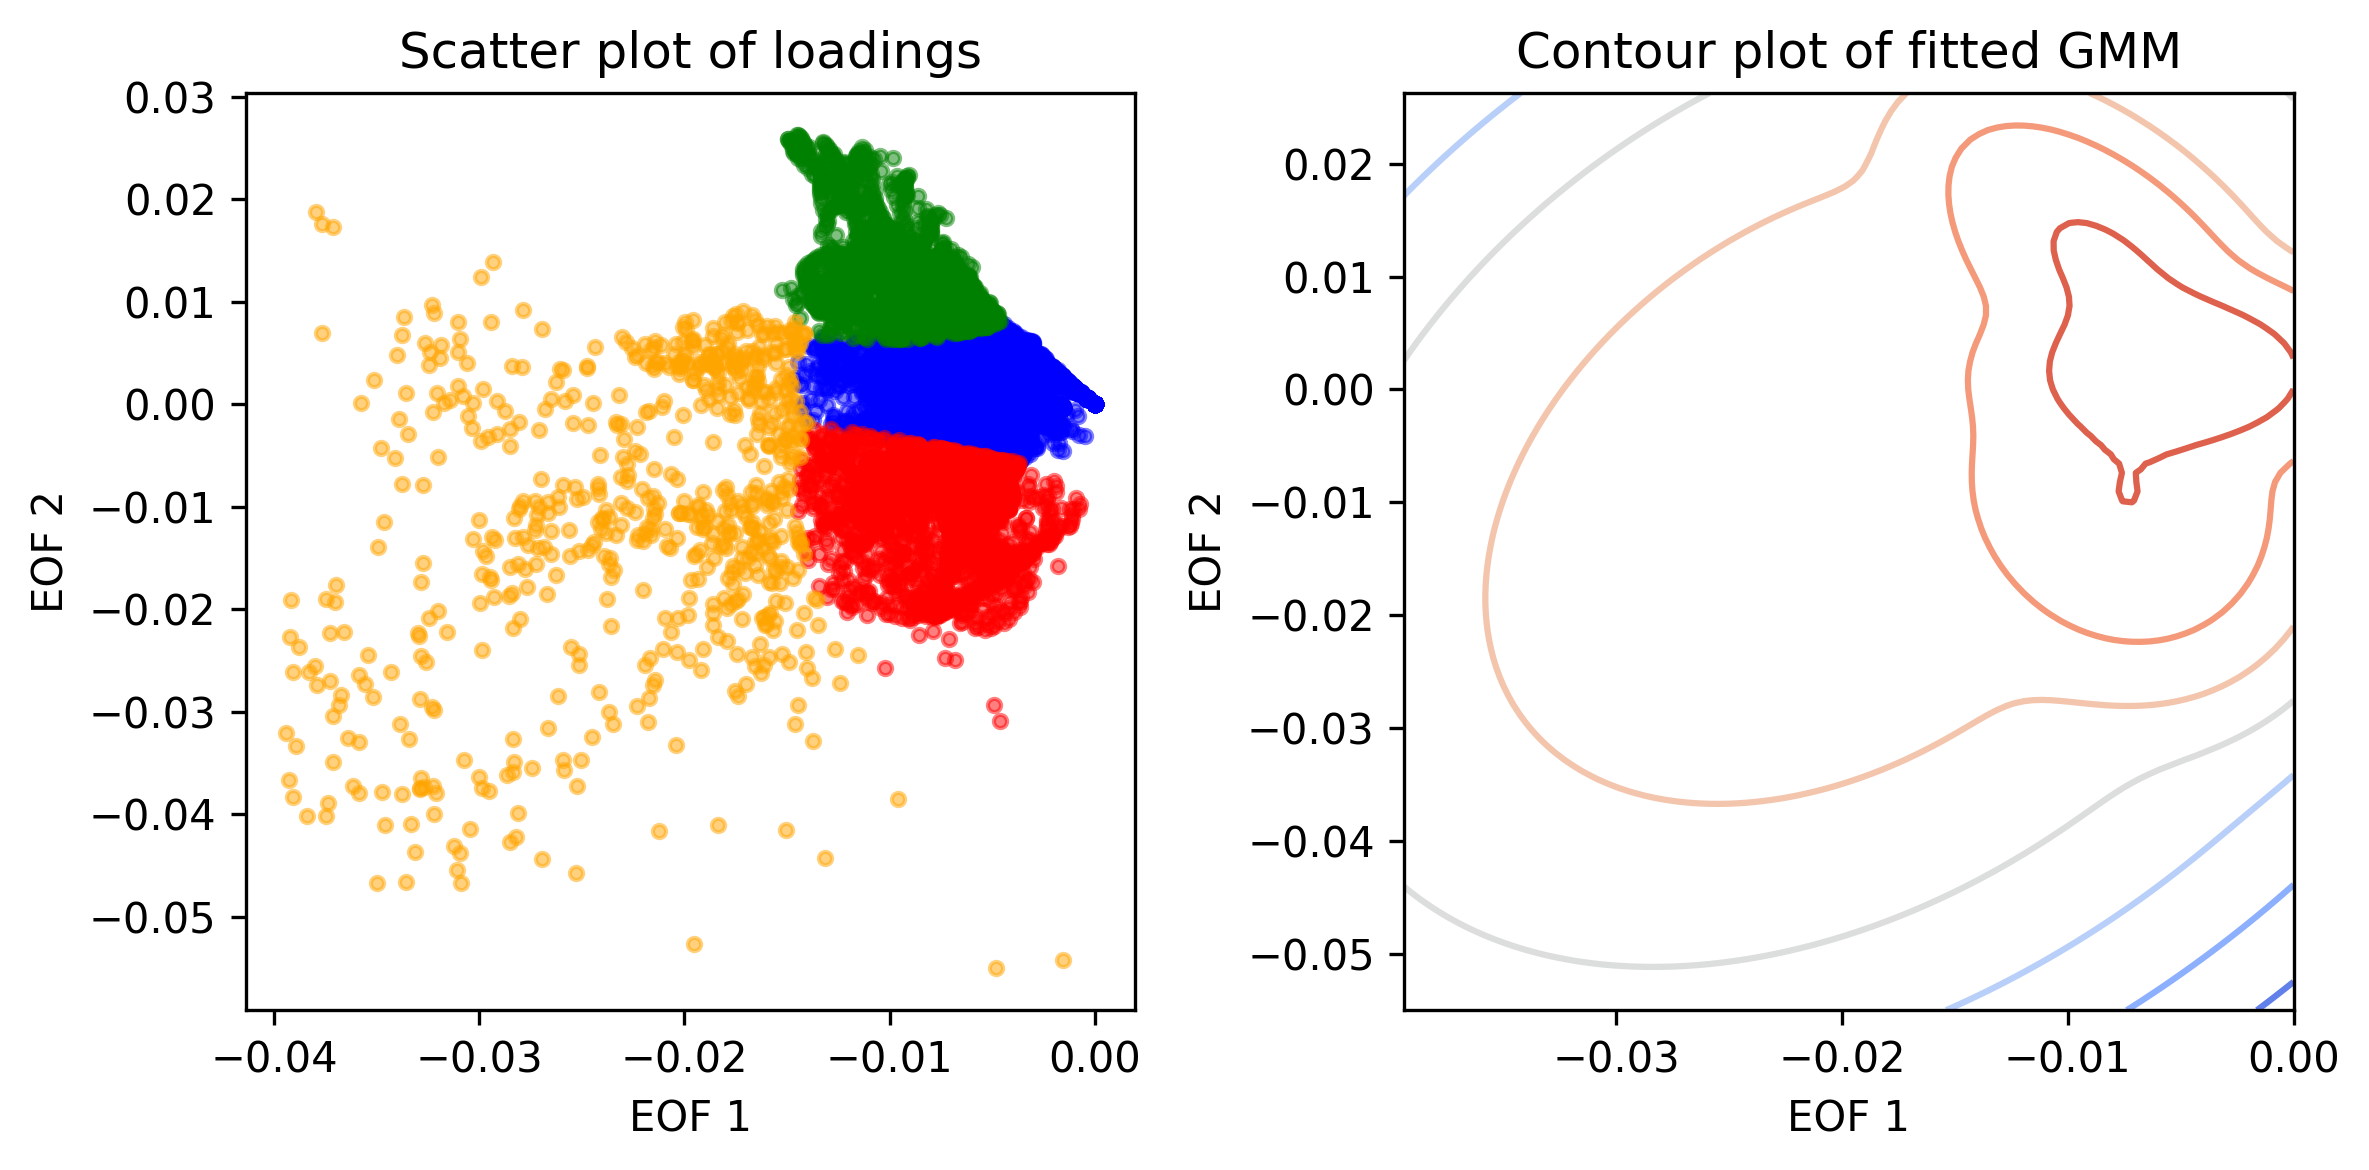

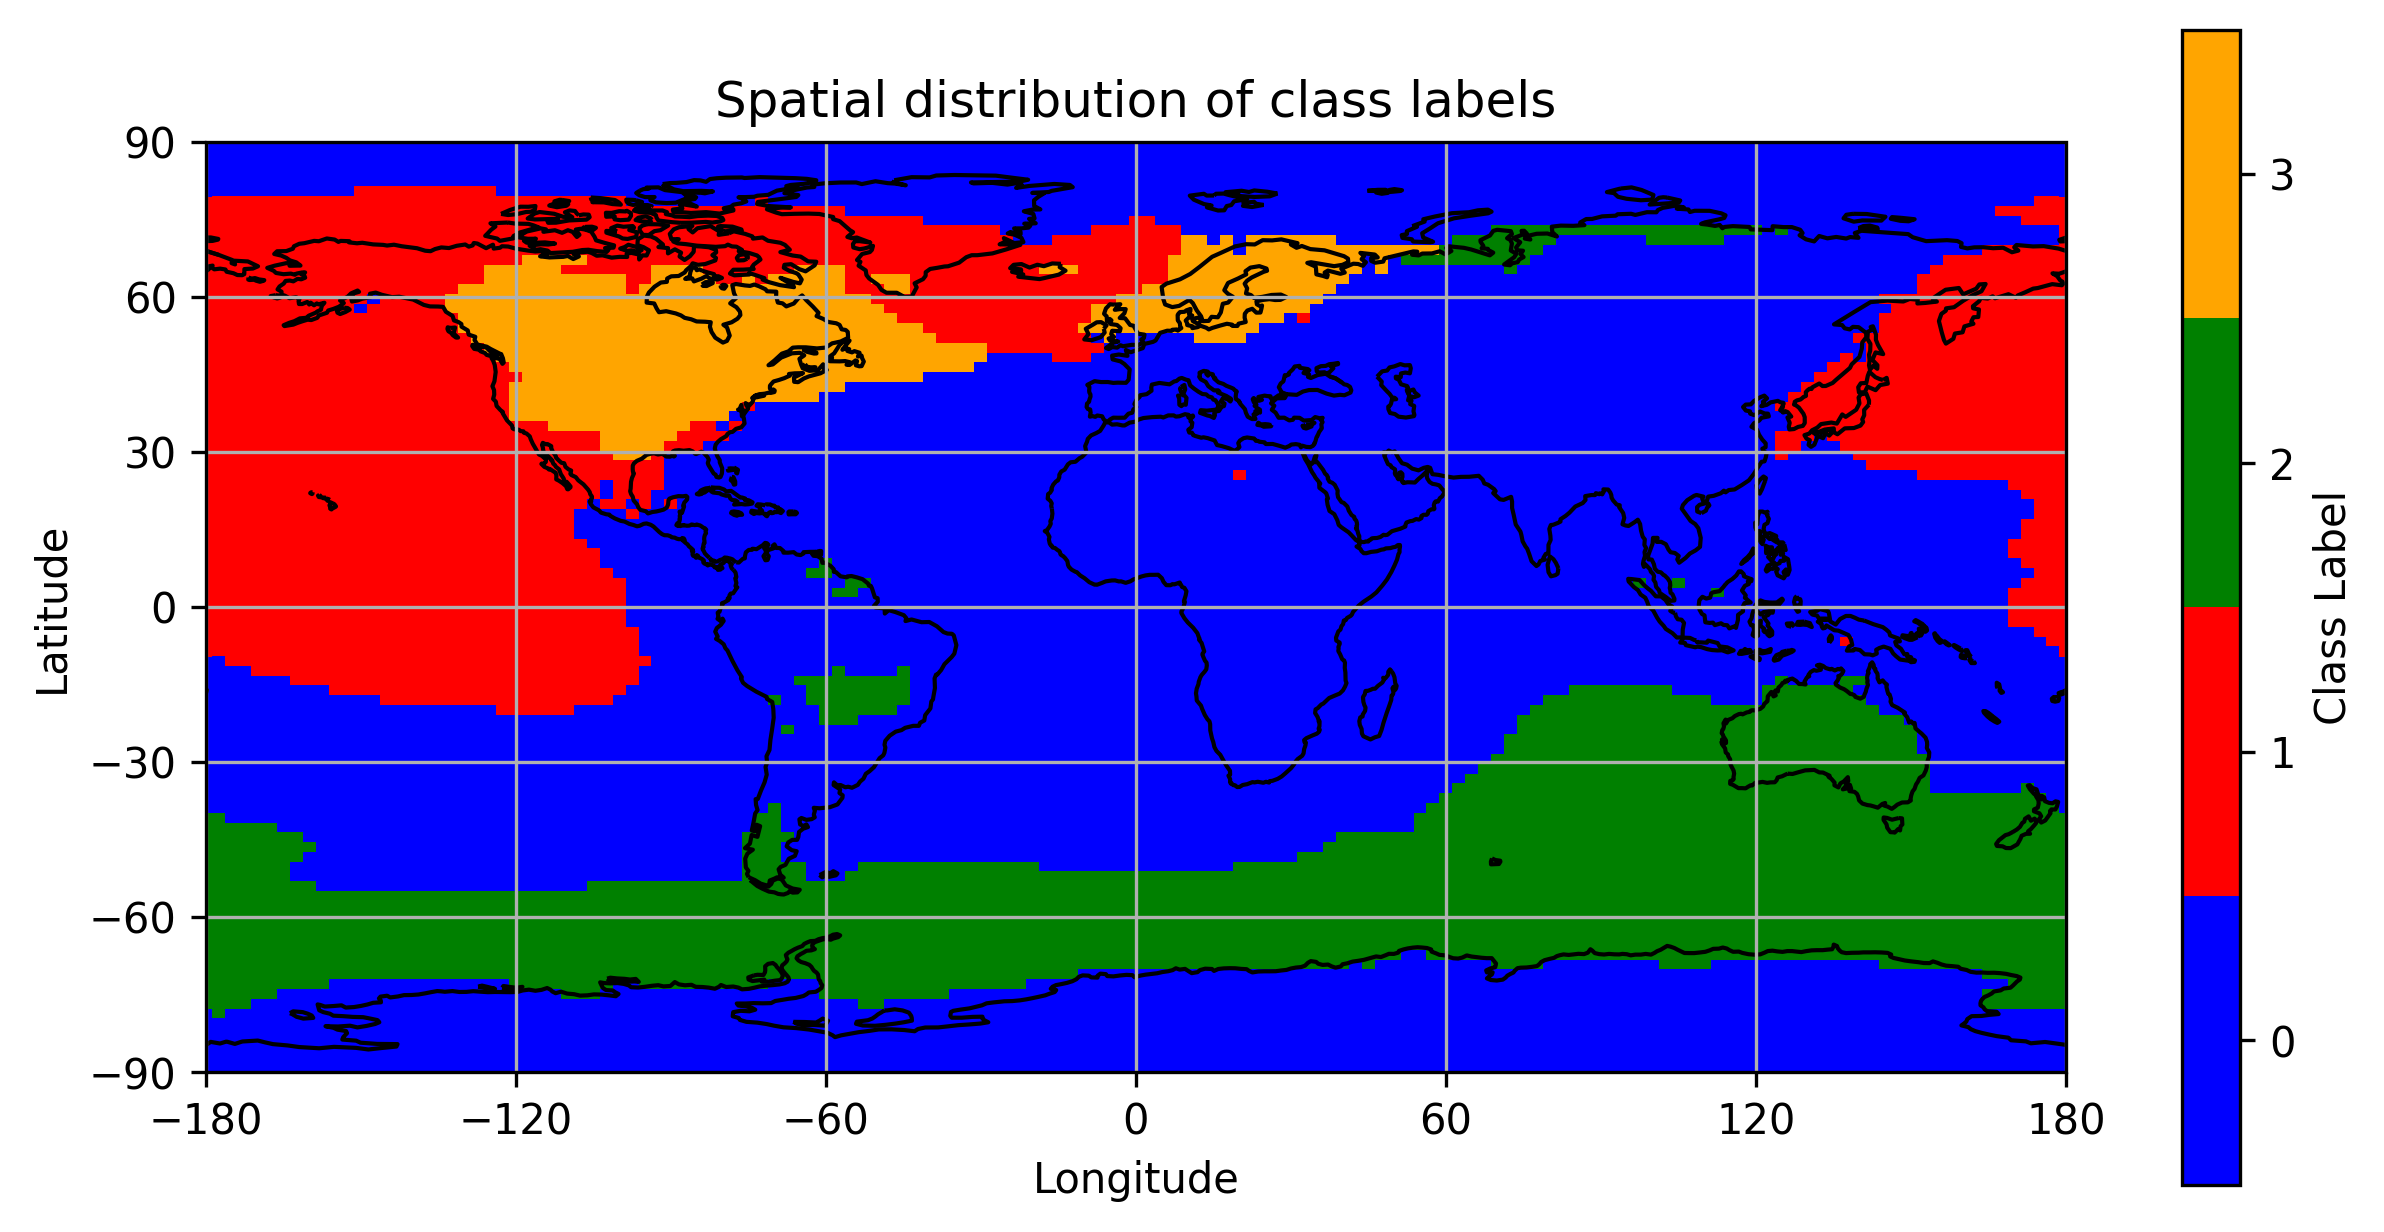

In [4]:
from toolbox import GMM_functions as gf
ds_sat_EOFs_GMM=gf.GMM4EOFS(EOF_concatenated, ds_sat_EOFs,n_components=4)
gf.plot_labels(ds_sat_EOFs_GMM)

shape of the weight: (96,)


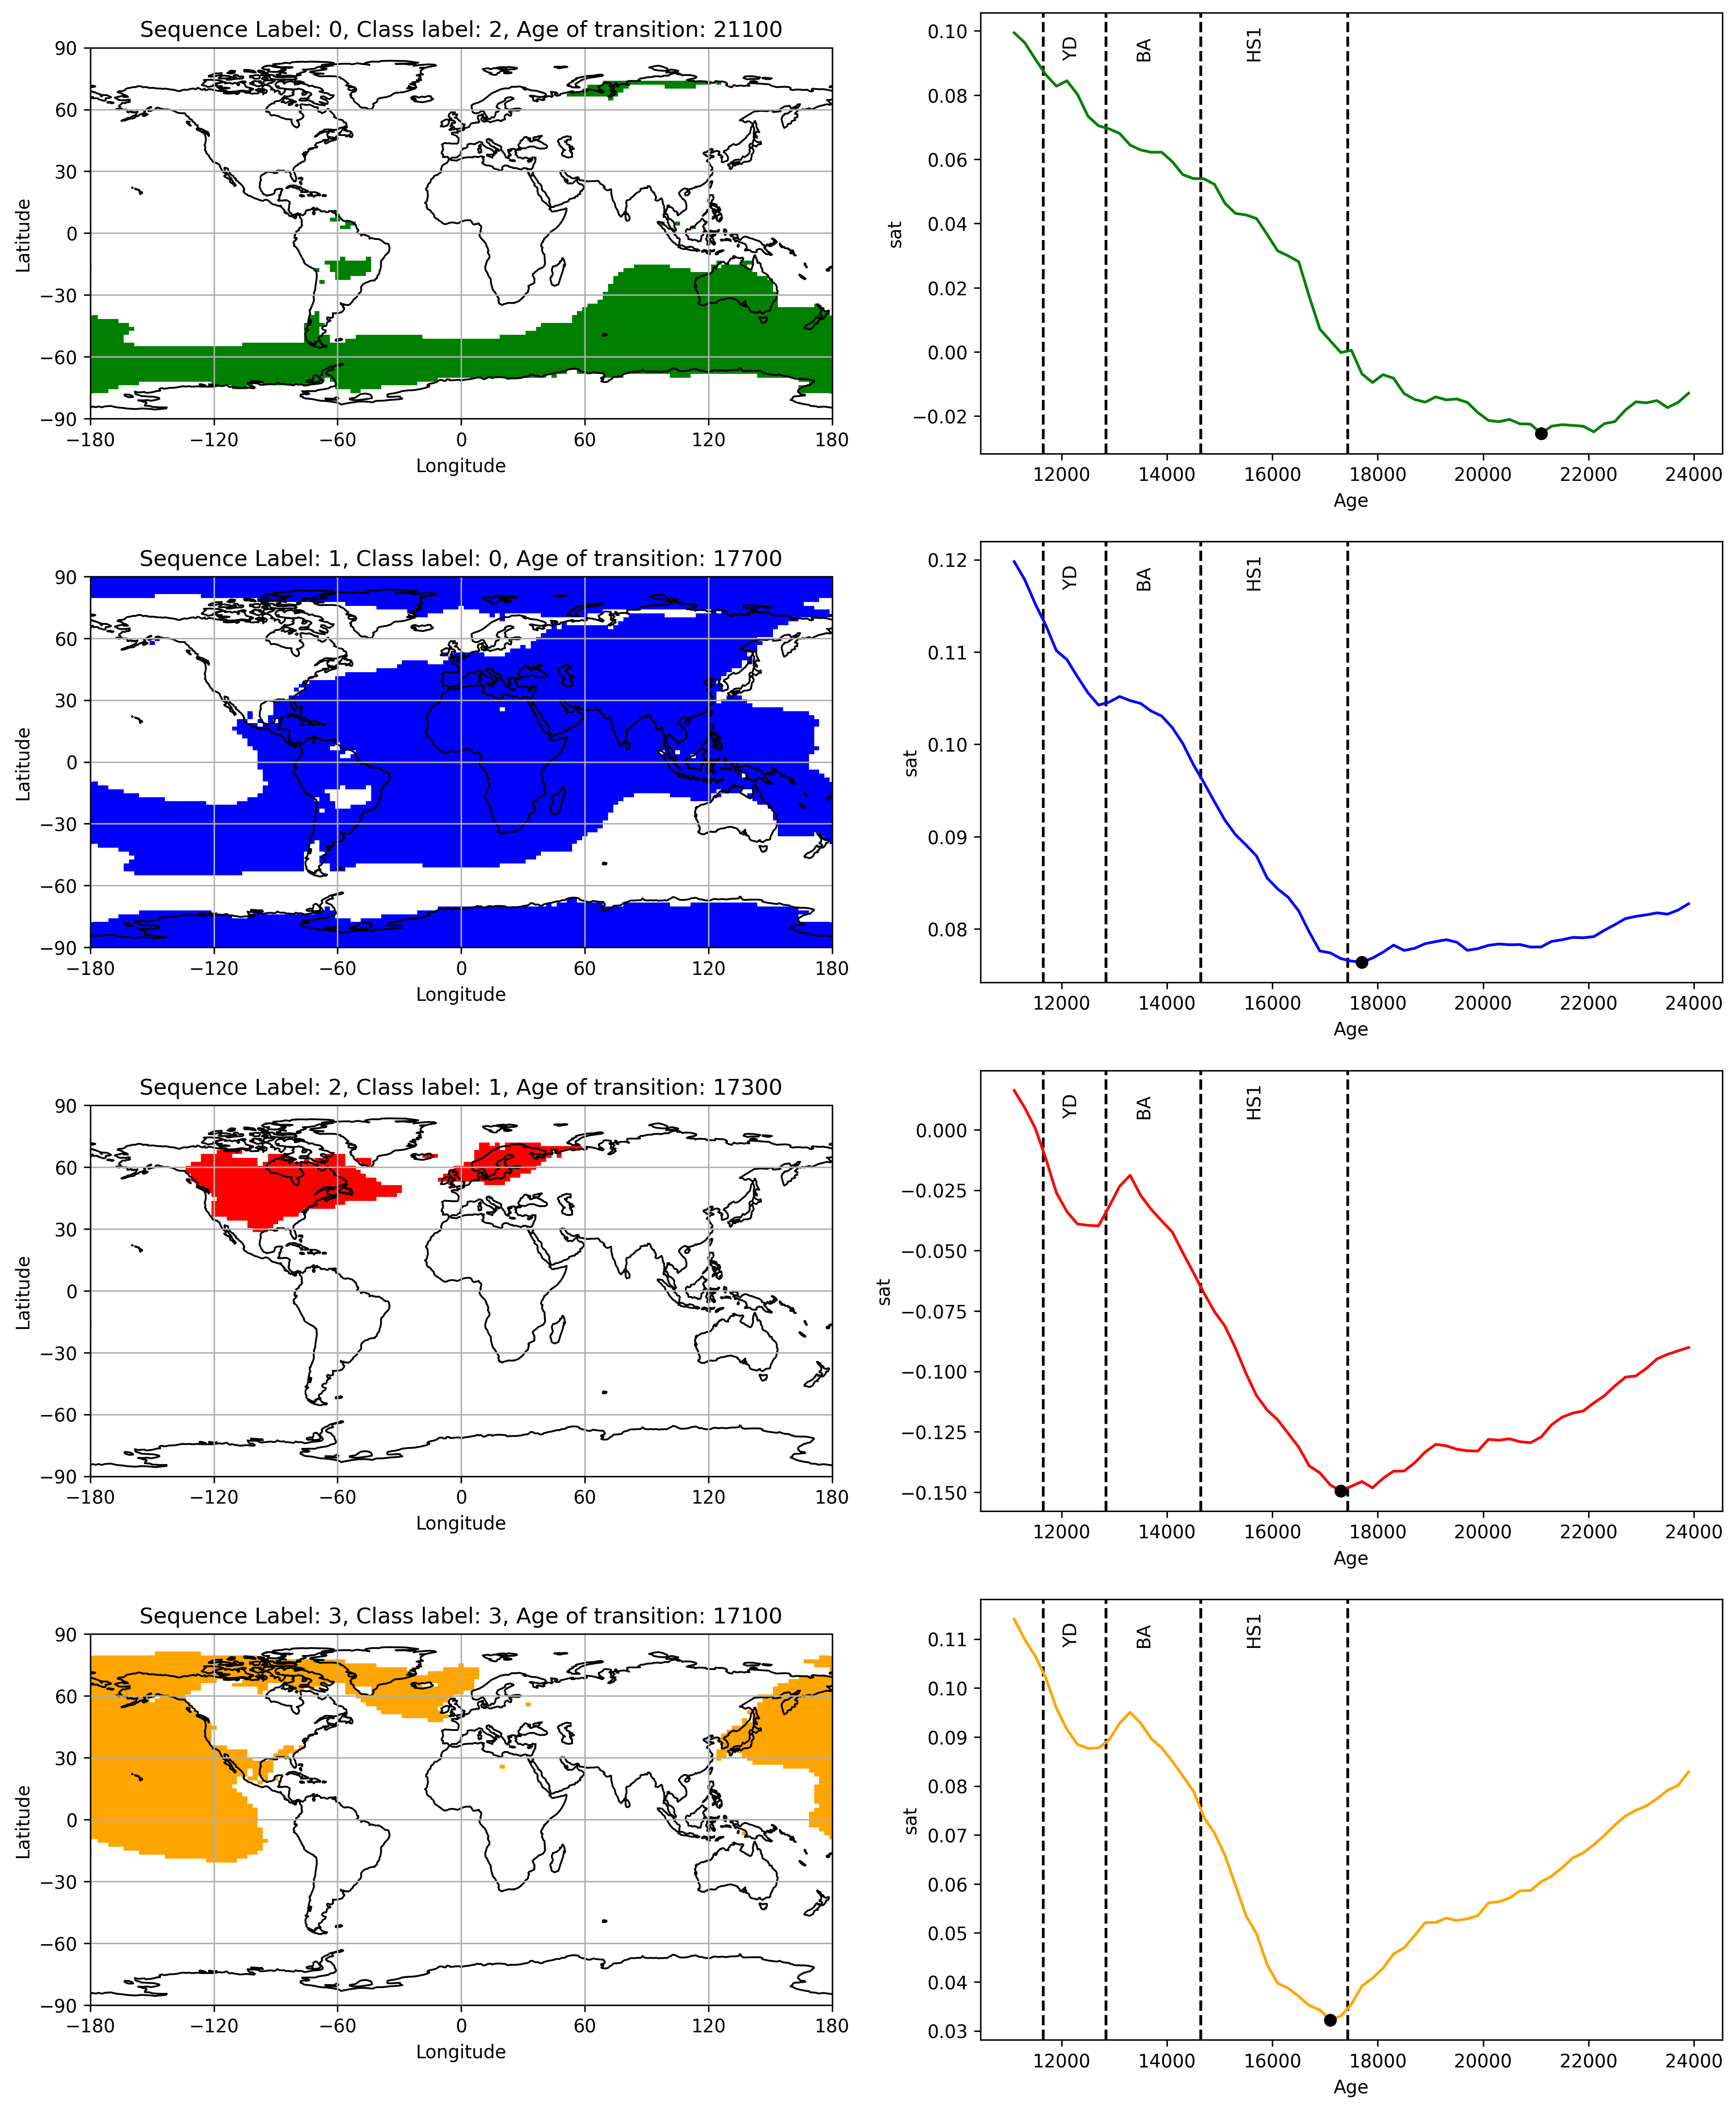

In [6]:
gf.plot_all_label_at_sequence(ds_sat_EOFs_GMM)

# Test the Bayesian changepoint detection

## method='b' means using Bayesian, method='min' means using the 'search the time where minimum happed' 


INFO: To supress printing the parameers in beast123(),   set extra.printOptions = 0  
INFO: To supress printing the parameers in beast(),      set print.options = 0 
INFO: To supress printing the parameers in beast.irreg(),set print.options = 0 
INFO: To supress warning messages in beast123(),         set extra.quiet = 1  
INFO: To supress warning messages in beast(),            set quiet = 1 
INFO: To supress warning messages in beast.irreg(),      set quiet = 1 

#--------------------------------------------------#
#       Brief summary of Input Data                #
#--------------------------------------------------#
Data Dimension: One signal of length 35
IsOrdered     : Yes, ordered in time
IsRegular     : Yes, evenly spaced at interval of  1 (unknown unit)
hasSeasonCmpnt: False | no periodic or seasonal component. The model Y=Trend+Error is fitted.
HasOutlierCmpt: False | If true, Y=Trend+Outlier+Error (experimental) is fitted instead of Y=Trend+Error 
Detrend       : False | I

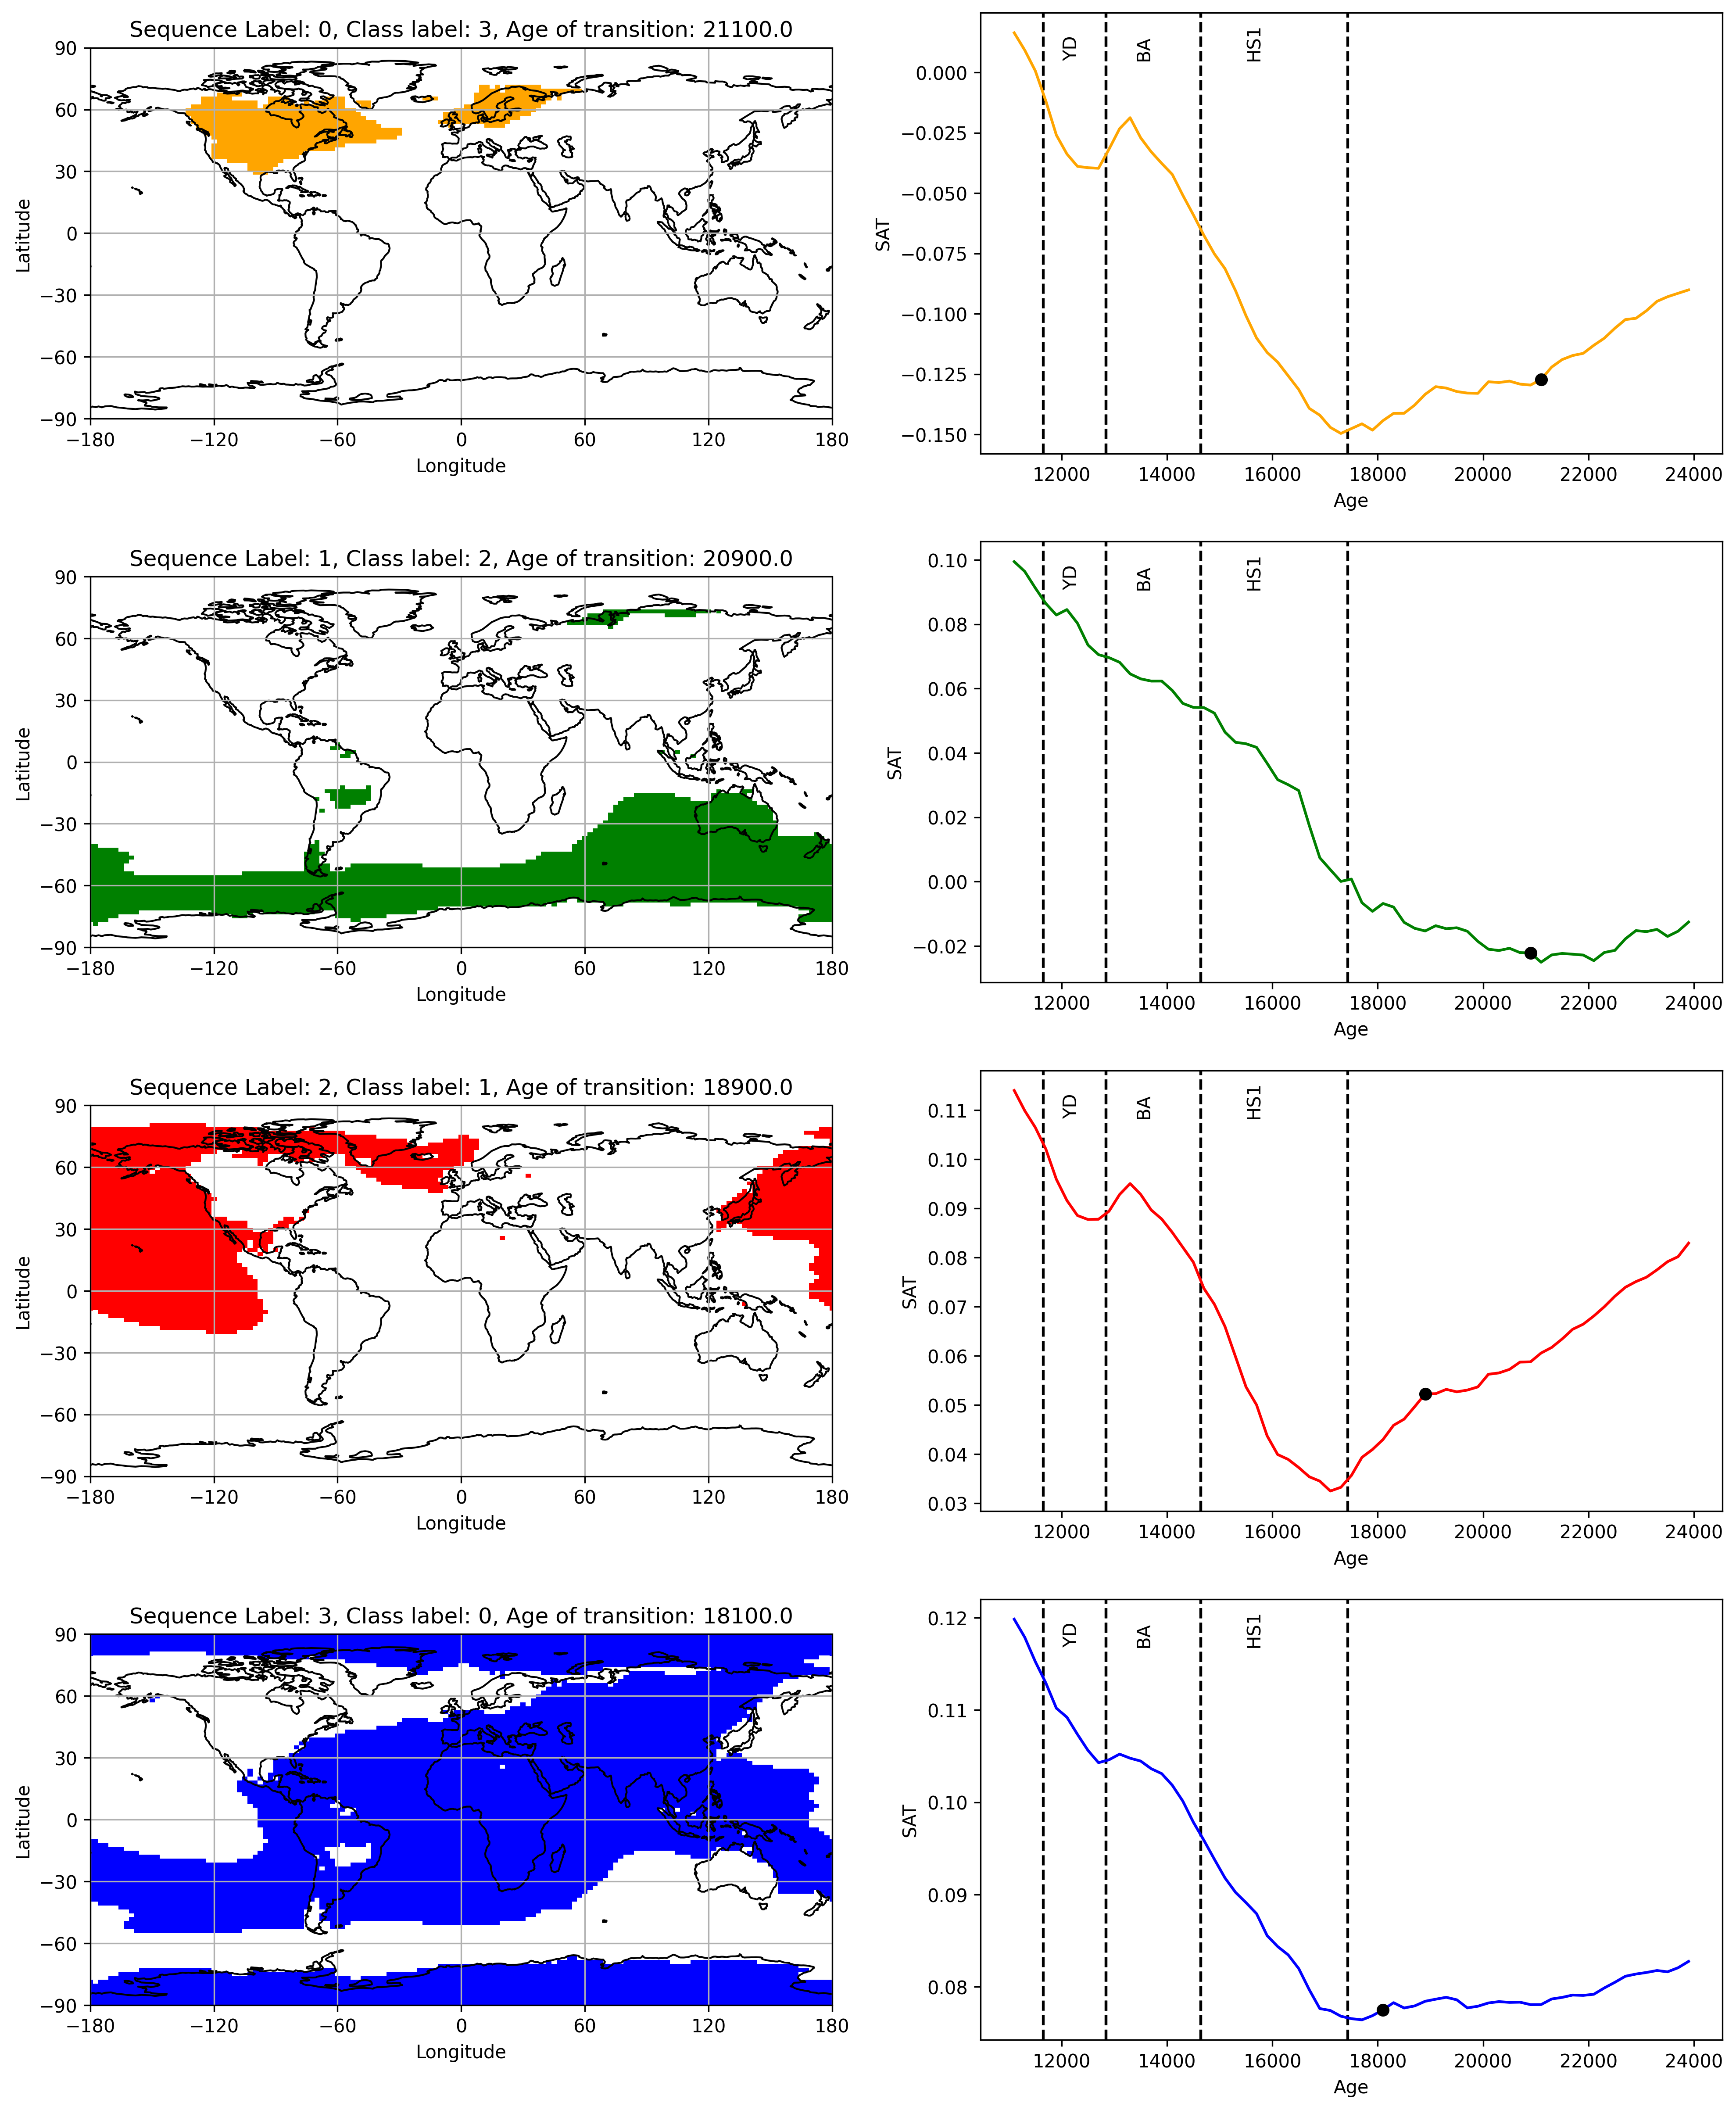

In [35]:
ds=ds_sat_EOFs_GMM
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature


method='b'
cp_age_list=[]
cp_sat_list=[]
label_list=[]
time_series_list=[]

for label in np.unique(ds['class_label']):
    # get the sat data of the class with lable==label
    label_mask = ds['class_label'] == label
    sat_of_class = ds['sat'].where(label_mask)

    weight_of_class=ds['weight'].where(label_mask)
    sat_of_class_weighted=sat_of_class*weight_of_class
    
    sat_of_class_weighted_average = sat_of_class_weighted.sum(dim=('lat', 'lon'))/weight_of_class.sum(dim=('lat', 'lon'))
    
    # find change points
    if method=='min':
        cp_age = ds['age'].isel(age=sat_of_class_weighted_average.argmin(dim='age'))
        # find the index of cp_age in ds['age']
        cp_age_index = np.where(ds['age'].values == cp_age.values)[0][0]
        cp_age=cp_age.values

        cp_sat = sat_of_class_weighted_average[cp_age_index].values

    if method=='b':
        # find the index where the ds['age'].values>=17000
        cut_off_index = np.where(ds['age'].values >= 17000)[0][0]

        shortened_data=sat_of_class_weighted_average.values[cut_off_index:]

        cp_age=find_cp_B(shortened_data)
        cp_age_index = np.where(ds['age'].values == cp_age)[0][0]
        cp_sat = sat_of_class_weighted_average[cp_age_index].values


    cp_age_list.append(cp_age)
    cp_sat_list.append(cp_sat)
    label_list.append(label)
    time_series_list.append(sat_of_class_weighted_average.values)

# to plot the map and time series
sorted_indices = np.argsort(cp_age_list)
sorted_indices_desc = sorted_indices[::-1]

nrow=len(label_list)
fig = plt.figure(figsize=(16, 5*nrow),dpi=300)
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

i=0
for indx in sorted_indices_desc:


    label=label_list[indx]
    cp_age=cp_age_list[indx]
    cp_sat=cp_sat_list[indx]
    sat_of_class_weighted_average=time_series_list[indx]
    
    # plot maps
    # add coastline and gridlines
    ax = fig.add_subplot(nrow, 2, 2*i+1, projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines()
    
    cmap = mcolors.ListedColormap(['#ffffff', colors[label]])
    im = ax.pcolormesh(ds.lon, ds.lat, ds['class_label'] ==label, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto')   
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    # add lon and lat labels
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Sequence Label: {i}, Class label: {label}, Age of transition: {cp_age}')

    # plot time series  
    ax1 = fig.add_subplot(nrow, 2, 2*i+2)

    # timing for climate transitions, data from Rasmussen et al., 2014, in b2k
    HS1=np.array([17480,14692])-50 # convert to b1950
    BA=np.array([14692,12896])-50
    YD=np.array([12896,11703])-50

    # plot the timing of climate transitions using vertical lines
    ax1.axvline(x=HS1[0],color='black',linestyle='--') # HS1
    ax1.axvline(x=HS1[1],color='black',linestyle='--') # HS1

    ax1.axvline(x=BA[0],color='black',linestyle='--') # BA
    ax1.axvline(x=BA[1],color='black',linestyle='--') # BA

    ax1.axvline(x=YD[0],color='black',linestyle='--') # YD
    ax1.axvline(x=YD[1],color='black',linestyle='--') # YD

    # plot the weighted average curve and the cps
    ax1.plot(ds.age,sat_of_class_weighted_average,color=colors[label])
    ax1.plot(cp_age,cp_sat,'ko')
    
    # add labels for the vertical lines
    ax1.text(HS1[0]-0.7*(HS1[0]-HS1[1]),np.max(ax1.get_ylim())-0.1*(np.max(ax1.get_ylim())-np.min(ax1.get_ylim())),'HS1',rotation=90)
    ax1.text(BA[0]-0.7*(BA[0]-BA[1]),np.max(ax1.get_ylim())-0.1*(np.max(ax1.get_ylim())-np.min(ax1.get_ylim())),'BA',rotation=90)
    ax1.text(YD[0]-0.7*(YD[0]-YD[1]),np.max(ax1.get_ylim())-0.1*(np.max(ax1.get_ylim())-np.min(ax1.get_ylim())),'YD',rotation=90)


    
    ax1.set_xlabel('Age')
    ax1.set_ylabel('SAT')

    i=i+1
    

# Some code to test the Bayesian changepoint detection

23900

INFO: To supress printing the parameers in beast123(),   set extra.printOptions = 0  
INFO: To supress printing the parameers in beast(),      set print.options = 0 
INFO: To supress printing the parameers in beast.irreg(),set print.options = 0 
INFO: To supress warning messages in beast123(),         set extra.quiet = 1  
INFO: To supress warning messages in beast(),            set quiet = 1 
INFO: To supress warning messages in beast.irreg(),      set quiet = 1 

#--------------------------------------------------#
#       Brief summary of Input Data                #
#--------------------------------------------------#
Data Dimension: One signal of length 65
IsOrdered     : Yes, ordered in time
IsRegular     : Yes, evenly spaced at interval of  1 (unknown unit)
hasSeasonCmpnt: False | no periodic or seasonal component. The model Y=Trend+Error is fitted.
HasOutlierCmpt: False | If true, Y=Trend+Outlier+Error (experimental) is fitted instead of Y=Trend+Error 
Detrend       : Fal

15700.0

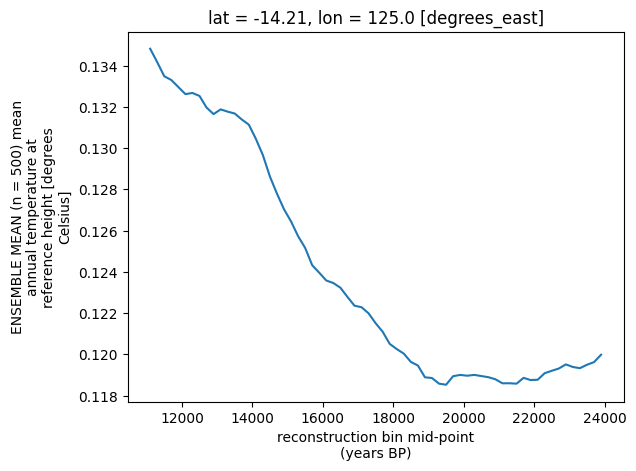

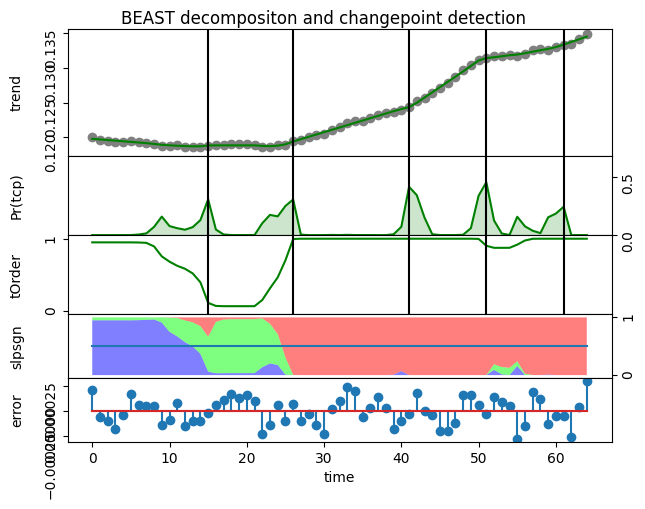

In [39]:
sample=ds_sat_EOFs['sat'].isel(lat=40,lon=50)
# plot the sample
sample.plot()
sample=sample.values
# flip the sample
sample=sample[::-1]

sat_start=int(ds_sat_EOFs['age'][-1].values)
print(sat_start)

import Rbeast as rb

o = rb.beast(sample, start=0,season='none')
rb.plot(o)

cp=o.trend.cp[0]
cp=ds_sat_EOFs['age'][-1].values-cp*200
cp

In [34]:
import numpy as np
def compute_cp_matrix(ds_sat_EOFs):
    lat_len = len(ds_sat_EOFs.lat)
    lon_len = len(ds_sat_EOFs.lon)
    
    # Initialize the matrix with zeros
    cp_matrix = np.zeros((lat_len, lon_len))
    
    for i, latitude in enumerate(ds_sat_EOFs.lat.values):
        for j, longitude in enumerate(ds_sat_EOFs.lon.values):
            data = ds_sat_EOFs.sat[:, i, j].values
            cp = find_cp_B(data)
            cp_matrix[i, j] = cp
            
    return cp_matrix

# Calculate the change point matrix
cp_matrix = compute_cp_matrix(ds_sat_EOFs)


NameError: name 'np' is not defined

In [43]:
np.diff(sample)

array([-3.60362232e-04, -1.26212835e-04, -1.66870654e-04,  5.71236014e-05,
        1.26786530e-04, -2.00636685e-04, -1.10030174e-04, -1.14537776e-04,
       -3.20203602e-04, -1.42455101e-05,  1.06558204e-04, -2.81818211e-04,
        2.01165676e-05, -2.65985727e-06,  1.95279717e-04,  1.01141632e-04,
        5.52833080e-05,  5.64455986e-05, -3.99425626e-05,  3.80799174e-05,
       -6.14672899e-05, -4.13544476e-04,  5.15952706e-05,  2.73086131e-04,
        3.58521938e-05,  5.71541488e-04,  1.73248351e-04,  4.02621925e-04,
        2.20775604e-04,  2.50712037e-04,  5.89378178e-04,  4.13969159e-04,
        4.79236245e-04,  2.95288861e-04,  7.53253698e-05,  4.24996018e-04,
        4.46200371e-04,  2.26721168e-04,  1.22144818e-04,  3.77595425e-04,
        3.63819301e-04,  8.37095082e-04,  5.68941236e-04,  7.14242458e-04,
        5.90026379e-04,  7.56263733e-04,  8.31007957e-04,  1.03664398e-03,
        7.96392560e-04,  6.86720014e-04,  2.49356031e-04,  2.90229917e-04,
        8.98092985e-05,  

Text(0.5, 1.0, 'np.diff(sample)')

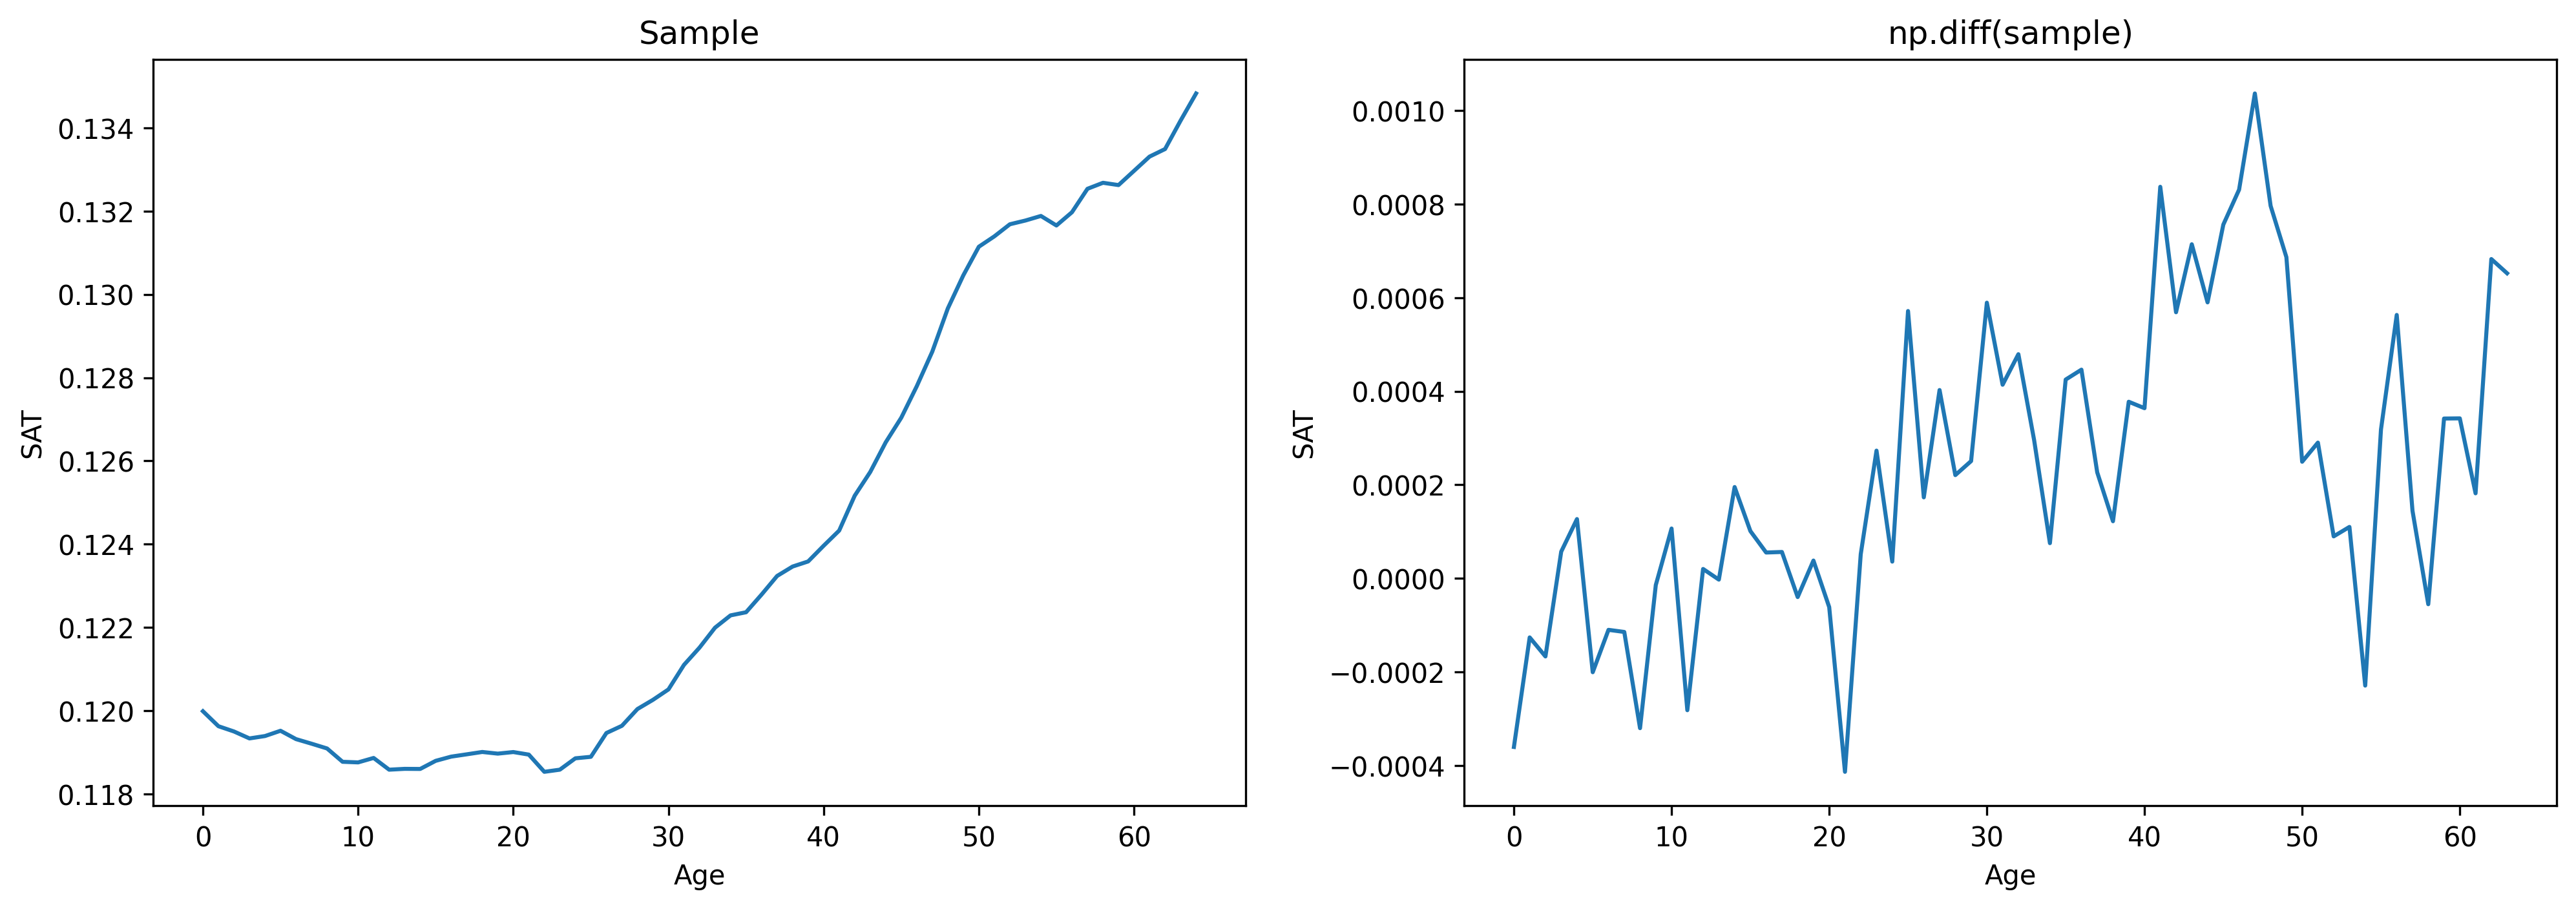

In [44]:
# plot sample and np.diff(sample)
fig = plt.figure(figsize=(16, 5),dpi=300)
ax1 = fig.add_subplot(121)
ax1.plot(sample)
ax1.set_xlabel('Age')
ax1.set_ylabel('SAT')
ax1.set_title('Sample')

ax2 = fig.add_subplot(122)
ax2.plot(np.diff(sample))
ax2.set_xlabel('Age')
ax2.set_ylabel('SAT')
ax2.set_title('np.diff(sample)')

In [41]:
o.trend.order


array([0.94954175, 0.94954175, 0.94954175, 0.94954175, 0.9492917 ,
       0.9492917 , 0.94766676, 0.9424168 , 0.89345837, 0.75491667,
       0.6819167 , 0.62450004, 0.58354175, 0.5191251 , 0.39575002,
       0.11058335, 0.06866667, 0.065125  , 0.06500001, 0.06495833,
       0.06512501, 0.06512501, 0.15062502, 0.31233335, 0.46400005,
       0.70033336, 0.9958334 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.9973334 , 0.9023751 , 0.8736667 , 0.8736667 , 0.87404174,
       0.9177084 , 0.97525   , 0.99883336, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ],
      dtype=float32)


INFO: To supress printing the parameers in beast123(),   set extra.printOptions = 0  
INFO: To supress printing the parameers in beast(),      set print.options = 0 
INFO: To supress printing the parameers in beast.irreg(),set print.options = 0 
INFO: To supress warning messages in beast123(),         set extra.quiet = 1  
INFO: To supress warning messages in beast(),            set quiet = 1 
INFO: To supress warning messages in beast.irreg(),      set quiet = 1 

#--------------------------------------------------#
#       Brief summary of Input Data                #
#--------------------------------------------------#
Data Dimension: One signal of length 100
IsOrdered     : Yes, ordered in time
IsRegular     : Yes, evenly spaced at interval of  1 (unknown unit)
hasSeasonCmpnt: False | no periodic or seasonal component. The model Y=Trend+Error is fitted.
HasOutlierCmpt: False | If true, Y=Trend+Outlier+Error (experimental) is fitted instead of Y=Trend+Error 
Detrend       : False | 

c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\Rbeast\plotbeast.py:294: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 640x480 with 5 Axes>,
 array([<AxesSubplot: xlabel='[]', ylabel='trend'>,
        <AxesSubplot: xlabel='[]', ylabel='Pr(tcp)'>,
        <AxesSubplot: xlabel='[]', ylabel='tOrder'>,
        <AxesSubplot: xlabel='[]', ylabel='slpsgn'>,
        <AxesSubplot: xlabel='time', ylabel='error'>], dtype=object))

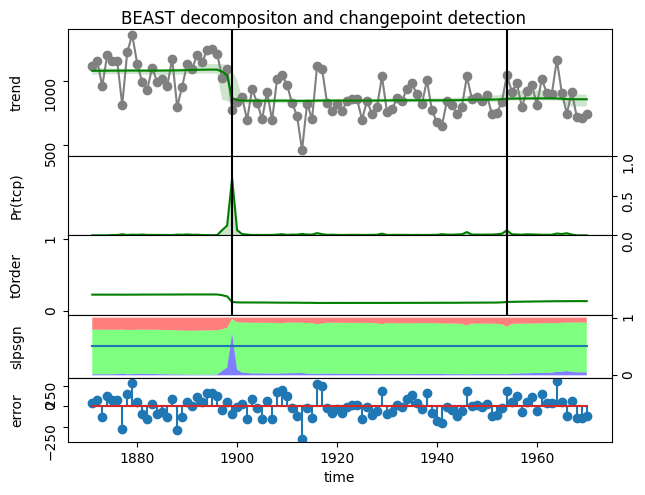

In [5]:
import Rbeast as rb

# Load an example dataset
(Nile, Year) = rb.load_example('nile')

# Run BEAST algorithm on the dataset
o = rb.beast(Nile, start=1871, season='none')

# Plot the results
rb.plot(o)


In [12]:
o.trend.cpPr

array([0.96975   , 0.10924992, 0.07520824, 0.07391658, 0.06499991,
       0.03933324, 0.03441667, 0.03354167, 0.03333324, 0.02395824],
      dtype=float32)

In [4]:
Nile

0     1120
1     1160
2      963
3     1210
4     1160
      ... 
95     746
96     919
97     718
98     714
99     740
Name: flow, Length: 100, dtype: int64

# Some code to test sizer_changepoint detection, not finished

## Modified from the MATLAB code from Abram et al., 2016. doi:10.1038/nature19082

In [45]:
import numpy as np

def sizer_changepoints(R, max_year, filter_clip):
    """
    changepoint screening function
    This function uses the output obtained from sizer analysis to screen for
    the starting point of sustained, significant climate trends.
    """
    # Convert R to a list of dictionaries if not already one.
    if not isinstance(R, list):
        R = [R]

    for j, r in enumerate(R):
        
        # load sizer output data
        x, y, z0, z90, zall = r["sizer_x"], r["sizer_y"], r["sizer_z0"], r["sizer_z90"], r["sizer_zall"]

        # find points of change in trend significance
        z90_ex = z90[:, 1:] - z90[:, :-1]

        # adjust for any changes from NaNs (flagged by -999)
        z90_ex[z90_ex == 1000] = -2
        z90_ex[z90_ex == 1003] = 1

        sig_year = np.zeros(z90.shape[0])
        sig_class = np.zeros(z90.shape[0])
        sigwarm_year = np.zeros(z90.shape[0])
        sigcool_year = np.zeros(z90.shape[0])

        # screen matrices to assess onset of most recent sustained and
        # significant trend
        # Assess for recent warming or cooling trend
        for i in range(z90.shape[0]):
            
            # Step 1: determine if most recent sig trend is warming or cooling
            # cooling = 4, warming = 1
            sigc = np.where(zall[i, :] == 4)[0]
            sigw = np.where(zall[i, :] == 1)[0]

            ysigc = x[0, sigc[-1]] if sigc.size else x[0, 0]
            ysigw = x[0, sigw[-1]] if sigw.size else x[0, 0]

            # assign classification
            if ysigc < ysigw:
                classification = 1  # warming
            elif ysigc > ysigw:
                classification = -1  # cooling
            else:
                classification = 0  # neutral

            # Step 2: determine if sign of most recent significant trend is
            # continuous to present
            if classification == -1:
                sigy_w = max_year
                w = np.where(zall[i, :] == 2)[0]
                yw = x[0, w[-1]] if w.size else x[0, 0]

                if yw > ysigc:
                    sigy = max_year
                    sigy_c = sigy
                else:
                    sigc = np.where(z90_ex[i, :] == 1)[0]
                    sigy = x[0, sigc[-1] + 1] if sigc.size else x[0, 0]
                    sigy_c = sigy

            elif classification == 1:
                sigy_c = max_year
                c = np.where(zall[i, :] == 3)[0]
                yc = x[0, c[-1]] if c.size else x[0, 0]

                if yc > ysigw:
                    sigy = max_year
                    sigy_w = sigy
                else:
                    sigw = np.where(z90_ex[i, :] == -2)[0]
                    sigy = x[0, sigw[-1] + 1] if sigw.size else x[0, 0]
                    sigy_w = sigy

            else:  # class = 0
                sigy = max_year
                sigy_w = sigy
                sigy_c = sigy

            sig_year[i] = sigy
            sig_class[i] = classification
            sigwarm_year[i] = sigy_w
            sigcool_year[i] = sigy_c

        # calculate medians across selected filter widths (11-50y), and save to array
        sigwarm_median = np.median(sigwarm_year[filter_clip:])
        sigcool_median = np.median(sigcool_year[filter_clip:])

        r["cp"] = {
            "sig_year": sig_year,
            "sig_class": sig_class,
            "sigwarm_year": sigwarm_year,
            "sigcool_year": sigcool_year,
            "sigwarm_median": sigwarm_median,
            "sigcool_median": sigcool_median,
            "filter_clip": filter_clip,
            "max_year": max_year
        }

    return R


In [46]:
import numpy as np

# The sizer_changepoints function goes here (as provided in the previous response)

# Example Data
R_sample = [
    {
        "sizer_x": np.array([[1980, 1981, 1982, 1983, 1984]]), 
        "sizer_y": np.array([[0.5, 0.6, 0.7, 0.6, 0.8]]),
        "sizer_z0": np.array([[0, 0, 0, 0, 0]]),
        "sizer_z90": np.array([[0, 1, 0, -1, 0]]),
        "sizer_zall": np.array([[1, 3, 2, 4, 2]])
    },
    # ... add more data samples as needed
]

max_year = 1984
filter_clip = 2

# Call the function
results = sizer_changepoints(R_sample, max_year, filter_clip)

# Print results
for result in results:
    print(result["cp"])


{'sig_year': array([1984.]), 'sig_class': array([-1.]), 'sigwarm_year': array([1984.]), 'sigcool_year': array([1984.]), 'sigwarm_median': nan, 'sigcool_median': nan, 'filter_clip': 2, 'max_year': 1984}


c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
